In [1]:
import os
from collections import defaultdict

import pandas as pd
import numpy as np
from scipy.stats import spearmanr

import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text

# import brown from nltk
from nltk.corpus import brown

import statsmodels.api as sm

sns.set(context='paper', style='ticks', font_scale=1)
sns.set_palette('colorblind')

## 1. Brown corpus analysis

### 1.1. General analysis

In [2]:
# lower case all words in the corpus
brown_words = [word.lower() for word in brown.words()]

In [3]:
len(brown_words)

1161192

In [4]:
# count indiivdual word frequencies and length and store in a dictionary

words_ = defaultdict(dict)

for word in brown_words:
    # if word has non-alphabetic characters, skip
    if not word.isalpha():
        continue
    if word in words_:
        words_[word]['count'] += 1
    else:
        words_[word]['count'] = 1
        words_[word]['length'] = len(word)

In [5]:
# convert to df
words_df = pd.DataFrame(words_).T
# convert count to log frequency
words_df['frequency'] = words_df['count'] / words_df['count'].sum()
words_df['log_frequency'] = np.log(words_df['frequency'])
words_df['neg_log_frequency'] = -np.log(words_df['frequency'])

In [6]:
# round frequency to 0 and get words with max lengths
words_df['frequency_round'] = words_df['log_frequency'].round(0)
words_df['length'] = words_df['length'].astype(int)

# get words with max length by grouping by frequency_round
words_df_max_length = words_df.groupby('frequency_round').apply(
    lambda x: x[x['length'] == x['length'].max()])

In [7]:
words_df.shape

(40234, 6)

In [8]:
# get coordinates of words with max length
words_df_max_length['x'] = words_df_max_length['frequency_round']
words_df_max_length['y'] = words_df_max_length['length']
# remove duplicates by x and y
words_df_max_length = words_df_max_length.drop_duplicates(subset=['x', 'y'])

In [9]:
words_df

,count,length,frequency,log_frequency,neg_log_frequency,frequency_round
the,69971,3,0.071274,-2.641221,2.641221,-3.0
fulton,17,6,0.000017,-10.963844,10.963844,-11.0
county,155,6,0.000158,-8.753632,8.753632,-9.0
grand,48,5,0.000049,-9.925856,9.925856,-10.0
jury,67,4,0.000068,-9.592365,9.592365,-10.0
...,...,...,...,...,...,...
perelman,1,8,0.000001,-13.797057,13.797057,-14.0
exhaling,1,8,0.000001,-13.797057,13.797057,-14.0
aviary,1,6,0.000001,-13.797057,13.797057,-14.0
boucle,1,6,0.000001,-13.797057,13.797057,-14.0


Spearman's p-value: 0.0000000000


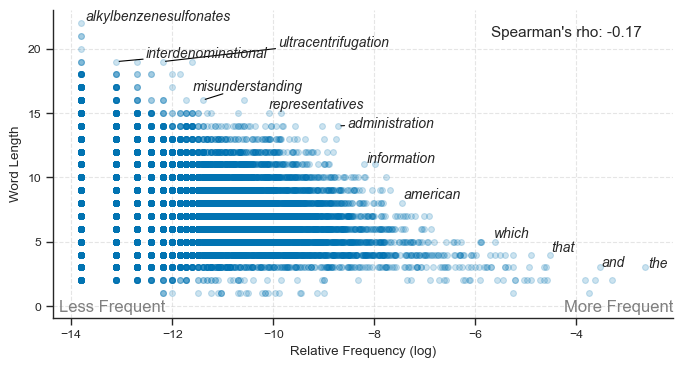

In [10]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.scatter(words_df['log_frequency'], 
            words_df['length'], 
            alpha=0.2, s=18)
# plot words with max length with labels using adjust_text
texts = []
for i, row in words_df_max_length.iterrows():
    texts.append(plt.text(row['log_frequency'], row['length'], i[1], fontsize=10, style='italic'))
adjust_text(texts, 
            arrowprops=dict(arrowstyle='-', 
                                   color='black'))
plt.ylabel('Word Length')
plt.xlabel('Relative Frequency (log)')
sns.despine()
plt.grid(alpha=0.5, linestyle='--')
# add spearman correlation to the plot in the top right corner
plt.annotate(f"Spearman's rho: {spearmanr(words_df['log_frequency'], words_df['length'])[0]:.2f}",
            xy=(0.95, 0.95), 
            xycoords='axes fraction', 
            ha='right', 
            va='top',
            fontsize=11)
# write more frequent at the bottom right corner and less frequent at the bottom left corner
plt.text(1, 0.01, 'More Frequent', ha='right', 
         va='bottom', fontsize=12, color = 'grey', 
         transform=ax.transAxes)
plt.text(0.01, 0.01, 'Less Frequent', ha='left', 
         va='bottom', fontsize=12, color = 'grey', 
         transform=ax.transAxes)
# print p-value
plt.ylim(-0.9, None)
print(f"Spearman's p-value: {spearmanr(words_df['log_frequency'], words_df['length'])[1]:.10f}")
plt.savefig('../figures/word_length_vs_log_frequency.png', dpi=300)
plt.savefig('../figures/word_length_vs_log_frequency.pdf', dpi=300, bbox_inches='tight')
plt.show()

### 1.2. Finding Pareto-optimal words

In [11]:
def non_dominated_front(points_x, points_y):
    """
    Returns the non-dominated (Pareto) front of a list of 2-D points using Kung's algorithm.
    """
    assert len(points_x) == len(points_y), "Number of x and y points must be the same"
    
    n = len(points_x)
    pareto_front = []
    dominated = [False] * n
    
    for i in range(n):
        for j in range(n):
            if i != j:
                if points_x[i] <= points_x[j] and points_y[i] <= points_y[j]:
                    if points_x[i] < points_x[j] or points_y[i] < points_y[j]:
                        dominated[j] = True
    
    for i in range(n):
        if not dominated[i]:
            pareto_front.append(i)
    
    return pareto_front

In [12]:
points_x = [3, 1, 4, 1, 5]
points_y = [2, 7, 1, 8, 2]

non_dominated_front(points_x, points_y)

[0, 1, 2]

In [13]:
freq = words_df['neg_log_frequency'].values
length = - words_df['length'].values

In [14]:
pareto = non_dominated_front(freq, length)

In [15]:
x_pareto = freq[pareto]
y_pareto = length[pareto]

lowess = sm.nonparametric.lowess
smoothed = lowess(y_pareto, x_pareto, frac=0.6)

In [16]:
pareto

[0, 16, 27, 122, 176, 433, 613, 1085, 1329, 1553, 11117, 15770, 31528, 34670]

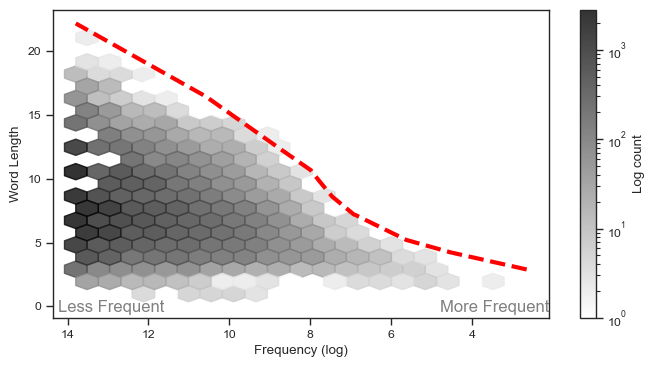

In [17]:
fig, ax = plt.subplots(figsize=(8, 4))
# plt.scatter(words_df['neg_log_frequency'], 
#             words_df['length'], 
#             alpha=0.2, s=18)
plt.hexbin(words_df['neg_log_frequency'], 
           words_df['length'],
           gridsize=20, # number of bins
           bins='log', # logarithmic scale
           cmap='binary', # colormap
           mincnt=1,
           alpha=0.8)
plt.plot(smoothed[:, 0], - smoothed[:, 1], 
         color = 'red', alpha=1, 
         linewidth=3, linestyle='--')
plt.ylabel('Word Length')
plt.xlabel('Frequency (log)')
plt.colorbar(label='Log count')
# flip x-axis
plt.gca().invert_xaxis()
# write more frequent at the bottom right corner and less frequent at the bottom left corner
plt.text(1, 0.01, 'More Frequent', ha='right', 
         va='bottom', fontsize=12, color = 'grey', 
         transform=ax.transAxes)
plt.text(0.01, 0.01, 'Less Frequent', ha='left', 
         va='bottom', fontsize=12, color = 'grey', 
         transform=ax.transAxes)
# print p-value
plt.ylim(-0.9, None)
plt.show()

## 2. Theoretical limit on word length

In [28]:
word_lengths_theoretical = defaultdict(int)

for i in range(1, 25):
    word_lengths_theoretical[i] = 26 ** i

In [29]:
# get a list of all english words from nltk
from nltk.corpus import words

# get the list of english words
english_words = words.words()

In [30]:
# lower
english_words = [word.lower() for word in english_words]
# remove duplicates
english_words = list(set(english_words))
len(english_words)

234377

In [31]:
# count number of words of each length
word_lengths = defaultdict(int)

for word in english_words:
    word_lengths[len(word)] += 1

# only keep words of length 1 to 8
word_lengths = {key: value for key, value in word_lengths.items()}

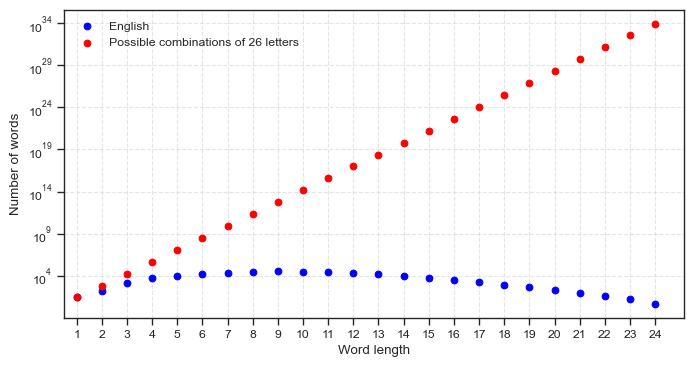

In [32]:
# plot the distribution of word lengths under 9
plt.figure(figsize=(8, 4))
# sns.lineplot(x=list(word_lengths.keys()), 
#              y=list(word_lengths.values()), 
#              color = 'blue', label = 'English')
plt.scatter(list(word_lengths.keys()),
            list(word_lengths.values()), 
            color = 'blue', label = 'English')
# plot the theoretical distribution of word lengths under 9
# sns.lineplot(x=list(word_lengths_theoretical.keys()), 
#              y=list(word_lengths_theoretical.values()),
#                color = 'red', 
#                alpha=1,
#                label = 'Possible combinations of 26 letters')
plt.scatter(list(word_lengths_theoretical.keys()),
            list(word_lengths_theoretical.values()), 
            color = 'red', label = 'Possible combinations of 26 letters')
plt.xlabel('Word length')
plt.ylabel('Number of words')
plt.grid(alpha=0.5, linestyle='--')
# log scale to show 10^1
plt.yscale('log', base=10)
plt.legend(loc='upper left', frameon=False)
plt.xlim(0.5, None)
# strart the x axis from 1
plt.xticks(range(1, 25))
plt.show()

## 3. Ferrer-i-Cancho and Bentz's data

In [33]:
# read csv files from data/FreqDists_50K
cwd = os.path.dirname(os.getcwd())
path = os.path.join(cwd, 'data', 'FreqDists_50K')
files = os.listdir(path)
csv_files = [file for file in files if file.endswith('.csv')]

In [34]:
results_b = defaultdict(list)

for file in csv_files:
    data = pd.read_csv(f'../data/FreqDists_50K/{file}')
    data['textfile'] = data['textfile'].astype(str)
    data['n_characters'] = [len(word) for word in data['textfile']]
    data['frequency'] = data['Freq'] / data['Freq'].sum()
    
    results_b['file'].append(file[:3])
    results_b['mean_length'].append(data['n_characters'].mean())
    # compute kendall tau for frequency and n_characters
    results_b['spearmans_rho'].append(data['frequency'].corr(data['n_characters'], method='spearman'))

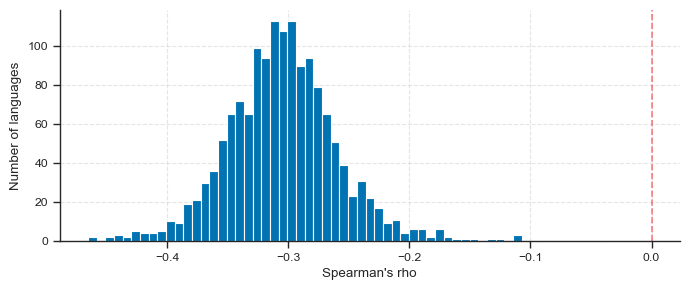

In [37]:
# plot kendall_tau distribution
plt.figure(figsize=(8, 3))
plt.hist(results_b['spearmans_rho'], bins=50, alpha=1, density=False)
# sns.kdeplot(results_b['spearmans_rho'], color='blue', linewidth=4, alpha=0.3)
plt.grid(alpha=0.5, linestyle='--')
plt.axvline(0, color='red', 
            linestyle='--', 
            alpha=0.5)
plt.xlabel('Spearman\'s rho')
plt.ylabel('Number of languages')
sns.despine()
plt.savefig('../figures/kendall_tau_distribution.png', bbox_inches='tight', dpi=300)
plt.savefig('../figures/kendall_tau_distribution.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [26]:
# print mean, max and min for results_b['kendall_tau'] rounded to 3 decimals
print(f'Mean: {np.mean(results_b["spearmans_rho"]):.3f}')
print(f'Max: {np.max(results_b["spearmans_rho"]):.3f}')
print(f'Min: {np.min(results_b["spearmans_rho"]):.3f}')

Mean: -0.305
Max: -0.107
Min: -0.466


In [27]:
len(results_b["spearmans_rho"])

1498